In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import KDTree
import cv2
from itertools import product
import sys
sys.path.append('../')

from skeletor.utils import courseGrainField, pathIntegralAlongField

import numba

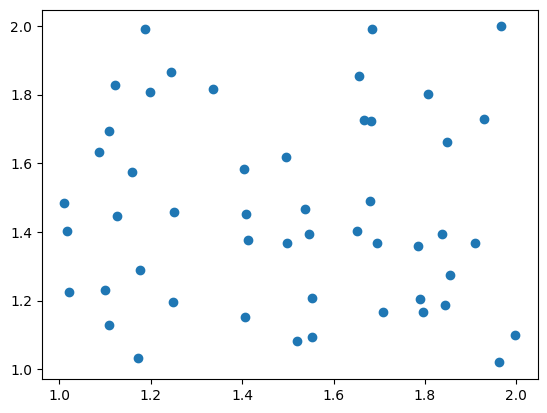

In [2]:
points = np.random.uniform(1, 2, size=(50,2))

plt.scatter(*points.T)
plt.show()

[1.01101223 1.01979339]


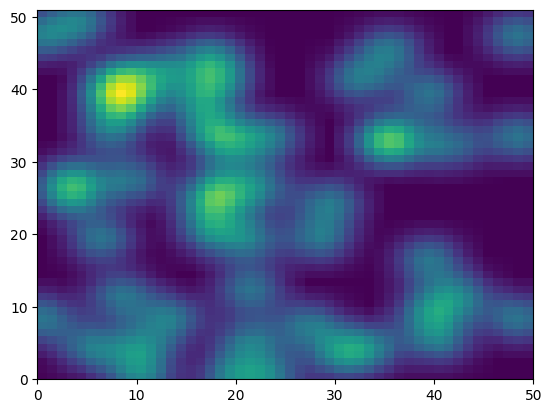

In [3]:
latticeSpacing = .02
field, corner = courseGrainField(points, latticeSpacing=latticeSpacing, kernelSize=11, returnCorner=True)
print(corner)
plt.pcolor(field)
plt.show()

In [82]:
@numba.njit()
def product(*iterables, repeat=1):
    # product('ABCD', 'xy') → Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) → 000 001 010 011 100 101 110 111

    pools = [tuple(pool) for pool in iterables] * repeat

    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]

    for prod in result:
        yield tuple(prod)

@numba.njit()
def pathIntegralAlongFieldFast(field, path, latticeSpacing=1, fieldOffset=None, debug=False):
    """
    Computes the path integral along a scalar discretized field in any
    dimension.

    Uses linear interpolation along the path, so works the best for smoothly-
    varying fields.

    Does not interpolate the steps along the path, so the input path steps
    should be appropriately broken up.

    Make sure that all of the quantities passed to this method use the same
    ordering of dimensions! For example, if you are integrating across an
    image, these often use y-x convention, whereas you may be tempted to
    put your path information in x-y format.
    
    Parameters
    ----------
    field : numpy.ndarray[N,M,...]
        Field over which to compute the path integral.

    path : numpy.ndarray[L,d]
        L ordered points representing a path
        through the field.

    latticeSpacing : float, or numpy.ndarray[d]
        The lattice spacing for the discretized field;
        can be a single value for all dimensions, or different
        values for each dimension.

    fieldOffset : numpy.ndarray[d] or None
        The position of the bottom left corner
        of the discrete lattice on which the field exists.

    debug : bool
        Whether to plot diagnostic information about the field
        and path. Only works if field is two dimensional.

    Returns
    -------
    result : float
    """
    d = field.ndim
    
    # Scale the path to have no units
    scaledPath = path.astype(np.float64)
    
    if fieldOffset is not None:
        scaledPath -= fieldOffset
    
    scaledPath /= latticeSpacing

    nearbyIndices = []
    for i in range(len(scaledPath)):
        #print(scaledPath[i])
        possibleIndices = []
        for j in range(d):
            possibleIndices.append(np.unique(np.array([np.floor(scaledPath[i,j]), np.ceil(scaledPath[i,j])])))
        #possibleIndices = np.array(possibleIndices)
        totalCombinations = int(np.nanprod(np.array([np.float64(len(p)) for p in possibleIndices])))
        
        # possibleIndices = [list(np.floor(scaledPath[i])), list(np.ceil(scaledPath[i]))]
        # possibleIndices = np.array(possibleIndices).T

        result = np.zeros((totalCombinations, d))
        result[:,0] = np.repeat(possibleIndices[0], totalCombinations // len(possibleIndices[1]))
        result[:,1] = list(possibleIndices[1])*(totalCombinations // len(possibleIndices[0]))
        #print(result)
        # This next part is mostly copied from itertools' product
        # function.
        #result = [[]]
        #for pool in possibleIndices:
        #   result = [x+[y] for x in result for y in pool]
            
        #print(result)
        # Removing duplicate indices (in case the path includes an exact integer
        # as a point) is faster one the entire list afterwards, instead
        # of doing a bunch of calls here.
        #possibleIndices = np.unique(possibleIndices, axis=-1)
        #possibleIndices = np.array([np.unique(p) for p in possibleIndices])
        #nearbyIndices.append(np.array(list(product(*possibleIndices))))
        nearbyIndices.append(result)

    
    fieldValuesAlongPath = np.zeros(len(scaledPath))

    for i in range(len(scaledPath)):
        #localPoints = np.unique(nearbyIndices[i], axis=0)
        localPoints = nearbyIndices[i]
        #print(localPoints)
        # Compute distances to each nearby point
        localDistances = np.sqrt(np.sum((scaledPath[i] - localPoints)**2, axis=-1))
        interpolationContributions = localDistances / np.sum(localDistances)
        # Now weight the values at the nearby points by their distances
        #fieldValuesAlongPath[i] = np.sum(interpolationContributions * np.array([field[tuple(np.int32(p))] for p in localPoints]))
        #print(field[tuple(localPoints.astype(np.int32).T)])
        #print(interpolationContributions)
        #print(np.int32(localPoints).T)
        #TODO
        #fieldValues = #np.take(field, localPoints.astype(np.int64))
        #fieldValuesAlongPath[i] = np.nansum(interpolationContributions * field[tuple(localPoints.astype(np.int32).T)])
        for j in range(d**2):
            fieldValue = field
            for k in range(d):
                fieldValue = fieldValue[int(localPoints[j][k])]
            
            #print(type(localPoints))
            #index = (localPoints.astype(np.int64)[j][0], localPoints.astype(np.int64)[j][1])
            #print(field[index])
            fieldValuesAlongPath[i] += interpolationContributions[j] * fieldValue

    # We need to weigh our numerical integration by the step size
    # We just to do a centered step scheme. ie. the interpolated value computed
    # above for point i "counts" for half of the path approaching point i, and
    # half of the path leaving point i. Thus, the first and last point are weighed
    # only half, since they don't have an incoming or outgoing path each.
    # We also have to scale back to the original lattice spacing.
    pathSpacings = np.sqrt(np.sum(((scaledPath[1:] - scaledPath[:-1])/latticeSpacing)**2, axis=-1))
    symSpacing = (pathSpacings[:-1] + pathSpacings[1:])/2
    symSpacing = np.concatenate((np.array([pathSpacings[0]/2]), symSpacing, np.array([pathSpacings[-1]/2])))

    pathIntegral = np.sum(symSpacing*fieldValuesAlongPath)
    
    # if debug and d == 2:
    #     axes = [np.arange(d) for d in np.shape(field)]
    #     points = np.array(np.meshgrid(*axes, indexing='ij')).T
    #     points = points.reshape(np.product(points.shape[:-1]), points.shape[-1])

    #     plt.imshow(field) # imshow reverses reads y,x, while the other two do x,y
    #     plt.scatter(*points.T[::-1], s=1, c='white')
    #     plt.plot(*scaledPath.T[::-1], '-o', c='red', markersize=2)
    #     plt.show()
    
    return pathIntegral


In [66]:
def pathIntegralAlongField(field, path, latticeSpacing=1, fieldOffset=None, debug=False):
    """
    Computes the path integral along a scalar discretized field in any
    dimension.

    Uses linear interpolation along the path, so works the best for smoothly-
    varying fields.

    Does not interpolate the steps along the path, so the input path steps
    should be appropriately broken up.

    Make sure that all of the quantities passed to this method use the same
    ordering of dimensions! For example, if you are integrating across an
    image, these often use y-x convention, whereas you may be tempted to
    put your path information in x-y format.
    
    Parameters
    ----------
    field : numpy.ndarray[N,M,...]
        Field over which to compute the path integral.

    path : numpy.ndarray[L,d]
        L ordered points representing a path
        through the field.

    latticeSpacing : float, or numpy.ndarray[d]
        The lattice spacing for the discretized field;
        can be a single value for all dimensions, or different
        values for each dimension.

    fieldOffset : numpy.ndarray[d] or None
        The position of the bottom left corner
        of the discrete lattice on which the field exists.

    debug : bool
        Whether to plot diagnostic information about the field
        and path. Only works if field is two dimensional.

    Returns
    -------
    result : float
    """
    d = np.array(field).ndim

    if not hasattr(latticeSpacing, '__iter__'):
        spacing = np.repeat(latticeSpacing, d)
    else:
        spacing = latticeSpacing
        
    if d == 2 and not debug:
        return _pathIntegralAlongField2D(field, path, spacing, fieldOffset)
    elif d == 3 and not debug:
        return _pathIntegralAlongField3D(field, path, spacing, fieldOffset)
    else:
        return _pathIntegralAlongFieldMulti(field, path, spacing, fieldOffset, debug)
    
@numba.njit()
def _pathIntegralAlongField2D(field, path, latticeSpacing=1, fieldOffset=None):
    """
    numba-optimized function to compute a path integral in 2D; designed
    to be called by `pathIntegralAlongField()` only.
    
    Parameters
    ----------
    field : numpy.ndarray[N,M]
        Field over which to compute the path integral.

    path : numpy.ndarray[L,2]
        L ordered points representing a path
        through the field.

    latticeSpacing : float, or numpy.ndarray[2]
        The lattice spacing for the discretized field;
        can be a single value for all dimensions, or different
        values for each dimension.

    fieldOffset : numpy.ndarray[2] or None
        The position of the bottom left corner
        of the discrete lattice on which the field exists.

    Returns
    -------
    result : float
    """
    d = field.ndim
    
    # Scale the path to have no units
    scaledPath = path.astype(np.float64)
    
    if fieldOffset is not None:
        scaledPath -= fieldOffset
    
    for i in range(d):
        scaledPath[:,i] /= latticeSpacing[i]

    nearbyIndices = []
    for i in range(len(scaledPath)):
        possibleIndices = []
        for j in range(d):
            possibleIndices.append(np.array([np.floor(scaledPath[i,j]), np.ceil(scaledPath[i,j])]))
        totalCombinations = int(np.prod(np.array([np.float64(len(p)) for p in possibleIndices])))

        # Have to manually index to make numba happy
        result = np.zeros((totalCombinations, d))
        result[:,0] = np.repeat(possibleIndices[0], totalCombinations // len(possibleIndices[1]))
        result[:,1] = list(possibleIndices[1])*(totalCombinations // len(possibleIndices[0]))
            
        nearbyIndices.append(result)

    fieldValuesAlongPath = np.zeros(len(scaledPath))

    for i in range(len(scaledPath)):
        localPoints = nearbyIndices[i]
        # Compute distances to each nearby point
        # Add some tiny amount to avoid divide by zero issues
        localDistances = np.sqrt(np.sum((scaledPath[i] - localPoints)**2, axis=-1)) + 1e-10
        interpolationContributions = localDistances / np.sum(localDistances)

        # Have to do some weird indexing to make numba happy, but generally this is
        # just the dot product between interpolationContributions and field[all indices]
        for j in range(2**d):
            index = (int(localPoints[j][0]), int(localPoints[j][1]))
            fieldValuesAlongPath[i] += interpolationContributions[j] * field[index]

    # We need to weigh our numerical integration by the step size
    # We just to do a centered step scheme. ie. the interpolated value computed
    # above for point i "counts" for half of the path approaching point i, and
    # half of the path leaving point i. Thus, the first and last point are weighed
    # only half, since they don't have an incoming or outgoing path each.
    # We also have to scale back to the original lattice spacing.
    unscaledPath = scaledPath[1:] - scaledPath[:-1]
    for i in range(d):
        unscaledPath[:,i] *= latticeSpacing[i]
        
    pathSpacings = np.sqrt(np.sum((unscaledPath)**2, axis=-1))
    symSpacing = (pathSpacings[:-1] + pathSpacings[1:])/2
    symSpacing = np.concatenate((np.array([pathSpacings[0]/2]), symSpacing, np.array([pathSpacings[-1]/2])))
    
    pathIntegral = np.sum(symSpacing*fieldValuesAlongPath)
        
    return pathIntegral


@numba.njit()
def _pathIntegralAlongField3D(field, path, latticeSpacing=1, fieldOffset=None):
    """
    numba-optimized function to compute a path integral in 3D; designed
    to be called by `pathIntegralAlongField()` only.
    
    Parameters
    ----------
    field : numpy.ndarray[N,M,...]
        Field over which to compute the path integral.

    path : numpy.ndarray[L,d]
        L ordered points representing a path
        through the field.

    latticeSpacing : float, or numpy.ndarray[d]
        The lattice spacing for the discretized field;
        can be a single value for all dimensions, or different
        values for each dimension.

    fieldOffset : numpy.ndarray[d] or None
        The position of the bottom left corner
        of the discrete lattice on which the field exists.

    Returns
    -------
    result : float
    """
    d = field.ndim
    
    # Scale the path to have no units
    scaledPath = path.astype(np.float64)
    
    if fieldOffset is not None:
        scaledPath -= fieldOffset

    for i in range(d):
        scaledPath[:,i] /= latticeSpacing[i]

    nearbyIndices = []
    for i in range(len(scaledPath)):
        possibleIndices = []
        for j in range(d):
            possibleIndices.append(np.array([np.floor(scaledPath[i,j]), np.ceil(scaledPath[i,j])]))
        totalCombinations = int(np.nanprod(np.array([np.float64(len(p)) for p in possibleIndices])))

        # Have to manually index to make numba happy
        result = np.zeros((totalCombinations, d))
        result[:,0] = np.repeat(possibleIndices[0], 4)
        result[:,1] = list(possibleIndices[1]) * 4
        result[:,2] = list(np.repeat(possibleIndices[2], 2)) * 2
        #print(result)
        nearbyIndices.append(result)

    fieldValuesAlongPath = np.zeros(len(scaledPath))

    for i in range(len(scaledPath)):
        localPoints = nearbyIndices[i]
        # Compute distances to each nearby point
        # Add some tiny amount to avoid divide by zero issues
        localDistances = np.sqrt(np.sum((scaledPath[i] - localPoints)**2, axis=-1)) + 1e-10
        interpolationContributions = localDistances / np.sum(localDistances)

        # Have to do some weird indexing to make numba happy, but generally this is
        # just the dot product between interpolationContributions and field[all indices]
        for j in range(2**d):
            index = (int(localPoints[j][0]), int(localPoints[j][1]), int(localPoints[j][2]))
            fieldValuesAlongPath[i] += interpolationContributions[j] * field[index]

    # We need to weigh our numerical integration by the step size
    # We just to do a centered step scheme. ie. the interpolated value computed
    # above for point i "counts" for half of the path approaching point i, and
    # half of the path leaving point i. Thus, the first and last point are weighed
    # only half, since they don't have an incoming or outgoing path each.
    # We also have to scale back to the original lattice spacing.
    unscaledPath = scaledPath[1:] - scaledPath[:-1]
    for i in range(d):
        unscaledPath[:,i] *= latticeSpacing[i]
        
    pathSpacings = np.sqrt(np.sum((unscaledPath)**2, axis=-1))
    symSpacing = (pathSpacings[:-1] + pathSpacings[1:])/2
    symSpacing = np.concatenate((np.array([pathSpacings[0]/2]), symSpacing, np.array([pathSpacings[-1]/2])))

    pathIntegral = np.sum(symSpacing*fieldValuesAlongPath)
        
    return pathIntegral

def _pathIntegralAlongFieldMulti(field, path, latticeSpacing=1, fieldOffset=None, debug=False):
    """
    Unoptimized path integral function, but can be used in
    an arbitrary spatial dimension, and give debug information.
    
    Parameters
    ----------
    field : numpy.ndarray[N,M,...]
        Field over which to compute the path integral.

    path : numpy.ndarray[L,d]
        L ordered points representing a path
        through the field.

    latticeSpacing : float, or numpy.ndarray[d]
        The lattice spacing for the discretized field;
        can be a single value for all dimensions, or different
        values for each dimension.

    fieldOffset : numpy.ndarray[d] or None
        The position of the bottom left corner
        of the discrete lattice on which the field exists.

    debug : bool
        Whether to plot diagnostic information about the field
        and path. Only works if field is two dimensional.

    Returns
    -------
    result : float
    """
    d = field.ndim

    # Scale the path to have no units
    scaledPath = path.astype(np.float64)

    if fieldOffset is not None:
        scaledPath -= fieldOffset

    scaledPath /= latticeSpacing

    nearbyIndices = []
    for i in range(len(scaledPath)):
        possibleIndices = [np.floor(scaledPath[i]), np.ceil(scaledPath[i])]
        # We don't need to worry about duplicates if floor(i) == ceil(i)
        # since we normalize the contributions at the end.
        possibleIndices = np.array(possibleIndices).T

        # This next part is mostly copied from itertools' product
        # function.
        result = [[]]
        for pool in possibleIndices:
           result = [x+[y] for x in result for y in pool]

        nearbyIndices.append(np.array(result))

    fieldValuesAlongPath = np.zeros(len(scaledPath))

    for i in range(len(scaledPath)):
        localPoints = nearbyIndices[i]
        # Compute distances to each nearby point
        # Add some tiny amount to avoid divide by zero issues
        localDistances = np.sqrt(np.sum((scaledPath[i] - localPoints)**2, axis=-1)) + 1e-10
        
        interpolationContributions = localDistances / np.sum(localDistances)
        # Now weight the values at the nearby points by their distances
        fieldValuesAlongPath[i] = np.nansum(interpolationContributions * field[tuple(localPoints.astype(np.int32).T)])

    # We need to weigh our numerical integration by the step size
    # We just to do a centered step scheme. ie. the interpolated value computed
    # above for point i "counts" for half of the path approaching point i, and
    # half of the path leaving point i. Thus, the first and last point are weighed
    # only half, since they don't have an incoming or outgoing path each.
    # We also have to scale back to the original lattice spacing.
    pathSpacings = np.sqrt(np.sum(((scaledPath[1:] - scaledPath[:-1]) * latticeSpacing)**2, axis=-1))
    symSpacing = (pathSpacings[:-1] + pathSpacings[1:])/2
    symSpacing = np.concatenate((np.array([pathSpacings[0]/2]), symSpacing, np.array([pathSpacings[-1]/2])))
    
    pathIntegral = np.sum(symSpacing*fieldValuesAlongPath)

    if debug and d == 2:
        axes = [np.arange(d) for d in np.shape(field)]
        points = np.array(np.meshgrid(*axes, indexing='ij')).T
        points = points.reshape(np.product(points.shape[:-1]), points.shape[-1])
        
        plt.imshow(field) # imshow reverses reads y,x, while the other two do x,y
        plt.scatter(*points.T[::-1], s=1, c='white')
        plt.plot(*scaledPath.T[::-1], '-o', c='red', markersize=2)
        plt.colorbar()
        plt.show()

    return pathIntegral


In [7]:
%timeit pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner, debug=False)

39.7 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
path = np.array([1.2, 1.2]) + np.array([x*np.array([.5, .5]) for x in np.linspace(0, 1, 50)])

pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner)

0.013707356452818118

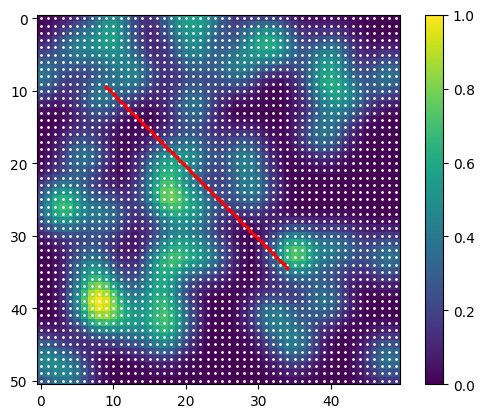

0.013707356452818115

In [8]:
path = np.array([1.2, 1.2]) + np.array([x*np.array([.5, .5]) for x in np.linspace(0, 1, 50)])

pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner, debug=True)

In [22]:
%timeit _pathIntegralAlongField2D(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner)
%timeit pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner, debug=False)

36.1 µs ± 988 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
38.8 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [67]:
oneField = np.ones((50,50))
onePath = np.array([1., 1.]) + np.array([x*np.array([0., 5.]) for x in np.linspace(0, 1, 50)])

pathIntegralAlongField(oneField, onePath, latticeSpacing=1)

4.999999999999997

In [23]:
points = np.random.uniform(1, 2, size=(500,3))

latticeSpacing = .02
field, corner = courseGrainField(points, latticeSpacing=latticeSpacing, kernelSize=11, returnCorner=True)
print(corner)

path = np.array([1.1, 1.1, 1.1]) + np.array([x*np.array([.8, .8, .8]) for x in np.linspace(0, 1, 500)])

print(pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner))
print(_pathIntegralAlongField3D(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner))

[1.00117393 1.00023763 1.00970548]
18.345446313575525
18.345446313575525


In [24]:
%timeit _pathIntegralAlongField3D(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner)
%timeit pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner, debug=False)

507 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
564 µs ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
